In [17]:
# standard data science libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [32]:
# autograd modules
from autograd import nn
from autograd.engine import Scalar
from autograd.visualize import draw_graph

In [5]:
# get toy dataset
from sklearn.datasets import make_moons, make_blobs

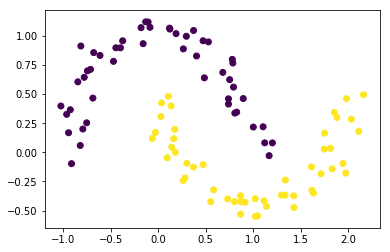

In [87]:
# prepare and visualze data
np.random.seed(1337)
random.seed(1337)
y = y*2 - 1 
X, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(X[:,0], X[:,1], c=y)

In [88]:
# create feed-forward multi-layer perceptron
# - 2 dimensional input data
# - 2 layers of 16 hidden units each
# - 1 unit output layer
model = nn.MLP(2, [16,16,1])
print(model)
print(f"\nNumber of trainable parameters: {len(model.parameters())}")

MLP([Layer([ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2),ReLUNeuron(2)]),Layer([ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16),ReLUNeuron(16)]),Layer([LinearNeuron(16)])])

Number of trainable parameters: 337


In [92]:
# define loss function
def calculate_loss(batch_size=None):
    if not batch_size:
        Xb, yb = X, y
    else:
        random_indexes = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[random_indexes], y[random_indexes]
    
    # initialize inputs as Scalars
    inputs = [list(map(Scalar, row)) for row in Xb]
    
    # forward propagation
    outputs = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -y_i*output_i).relu() for y_i, output_i in zip(yb, outputs)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularzation (adding sum of squares of weights to penalize large weights, times hyperparameter alpha)
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # calculate
    accuracy = [(y_i > 0) == (output_i.value > 0) for y_i, output_i in zip(yb, outputs)]
    return total_loss, sum(accuracy) / len(accuracy)

In [93]:
# training
def train(epochs=11, debug=False):
    for epoch in range(epochs):
        total_loss, accuracy = calculate_loss()
        
        # zero out previous gradients for next iteration of backpropagation
        model.zero_grad()
        
        # backprop
        total_loss.backward()
        
        # update parameters (stochastic gradient descent with learning rate decay)
        learning_rate = 1.0 - 0.9*epoch/100
        
        for parameter in model.parameters():
            if debug:
                print('before',parameter.value,'grad',parameter.grad)
            parameter.value -= learning_rate * parameter.grad
            if debug:
                print('after',parameter.value)
        if epoch % 5 == 0:
            print(f"Epoch: {epoch}, Loss: {total_loss.value}, Accuracy: {accuracy*100}%")

In [94]:
train()

Epoch: 0, Loss: 0.5, Accuracy: 50.0%
Epoch: 5, Loss: 0.5, Accuracy: 50.0%
Epoch: 10, Loss: 0.5, Accuracy: 50.0%
